In [59]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

In [60]:
DATASET_DIR = "malimg_paper_dataset_imgs"
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 10

FINE_TUNE = True
FINE_TUNE_AT = 100
FINE_TUNE_EPOCHS = 10 

In [61]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print("\nClasses:",class_names, "\n")

for image_batch, labels_batch in train_ds:
  print("Images shape:",image_batch.shape)
  print("Labels shape:",labels_batch.shape)
  break

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 9339 files belonging to 25 classes.
Using 7472 files for training.
Found 9339 files belonging to 25 classes.
Using 1867 files for validation.

Classes: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A'] 

Images shape: (32, 224, 224, 3)
Labels shape: (32, 25)


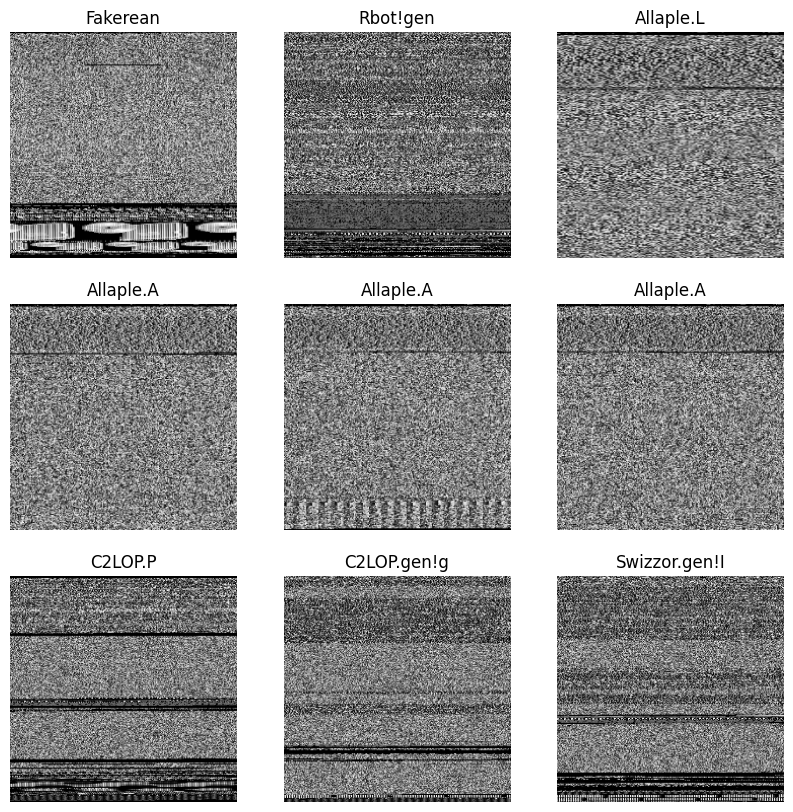

In [62]:
def vecToint(vec):
  return np.argmax(vec)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[vecToint(labels[i])])
    plt.axis("off")

In [63]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
#base_model.summary()

In [64]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs) 
x = base_model(x, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(12)(x)
outputs = tf.keras.layers.Dense(25, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 12)                1537

In [65]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("normal", verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=1e-8, verbose=1),
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_ds)

Epoch 1/10


/home/simon/.local/lib/python3.10/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


234/234 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.8461
Epoch 1: val_loss improved from inf to 0.21444, saving model to normal
234/234 [==============================] - 50s 208ms/step - loss: 0.6315 - accuracy: 0.8461 - val_loss: 0.2144 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 2/10
234/234 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9491
Epoch 2: val_loss improved from 0.21444 to 0.12078, saving model to normal
234/234 [==============================] - 48s 205ms/step - loss: 0.1799 - accuracy: 0.9491 - val_loss: 0.1208 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 3/10
234/234 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9624
Epoch 3: val_loss improved from 0.12078 to 0.09659, saving model to normal
234/234 [==============================] - 47s 202ms/step - loss: 0.1173 - accuracy: 0.9624 - val_loss: 0.0966 - val_accuracy: 0.9743 - lr: 0.0010
Epoch 4/10
234/234 [==============================] - ETA: 0s

Max accuracy: 0.9855 at epoch 6
Min loss: 0.0413 at epoch 9


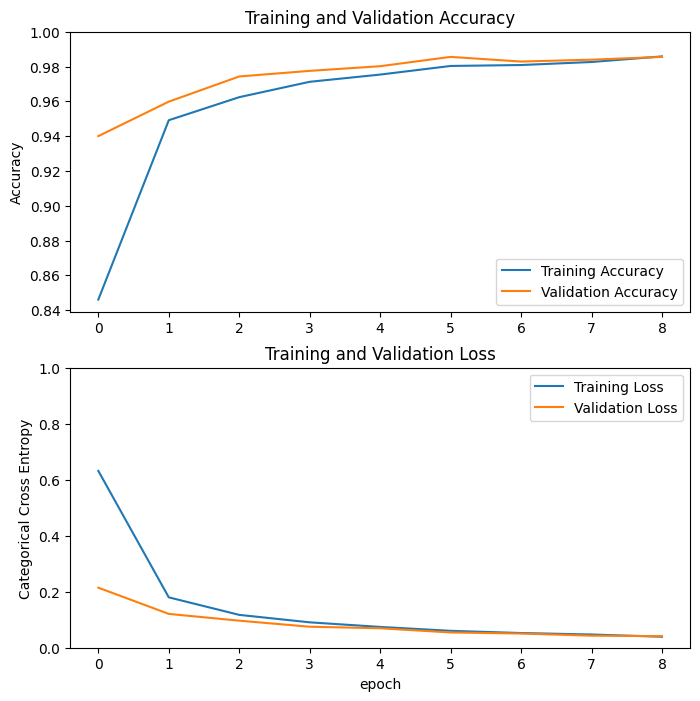

In [71]:
initial_epochs = len(history.history["loss"]) - 1 

print(f"Max accuracy: {round(max(history.history['val_accuracy']),4)} at epoch {np.argmax(history.history['val_accuracy'])+1}")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

print(f"Min loss: {round(min(history.history['val_loss']),4)} at epoch {np.argmin(history.history['val_loss'])+1}")
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [67]:
if FINE_TUNE:
    base_model.trainable = True
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:FINE_TUNE_AT]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=history.history["lr"][-1]/10),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("finetune", verbose=1, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=1e-8, verbose=1),
    ]

    total_epochs =  initial_epochs + FINE_TUNE_EPOCHS
    history_fine = model.fit(
        train_ds,
        epochs=total_epochs,
        validation_data=val_ds,
        callbacks=callbacks,
        initial_epoch=history.epoch[-1])

Epoch 9/18


/home/simon/.local/lib/python3.10/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


234/234 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9826
Epoch 9: val_loss improved from inf to 0.04122, saving model to finetune
234/234 [==============================] - 71s 288ms/step - loss: 0.0483 - accuracy: 0.9826 - val_loss: 0.0412 - val_accuracy: 0.9850 - lr: 1.0000e-05
Epoch 10/18
234/234 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9849
Epoch 10: val_loss improved from 0.04122 to 0.03529, saving model to finetune
234/234 [==============================] - 66s 282ms/step - loss: 0.0361 - accuracy: 0.9849 - val_loss: 0.0353 - val_accuracy: 0.9845 - lr: 1.0000e-05
Epoch 11/18
234/234 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9874
Epoch 11: val_loss improved from 0.03529 to 0.03386, saving model to finetune
234/234 [==============================] - 66s 282ms/step - loss: 0.0300 - accuracy: 0.9874 - val_loss: 0.0339 - val_accuracy: 0.9871 - lr: 1.0000e-05
Epoch 12/18
234/234 [==================

Top accuracy: 0.9855 at epoch 6
Top loss: 0.0413 at epoch 9


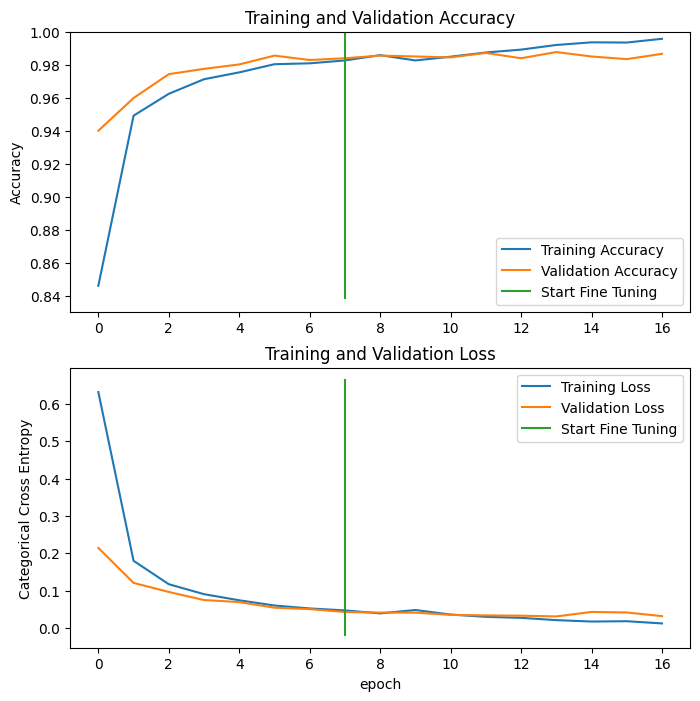

In [70]:
if FINE_TUNE:
    print(f"Max accuracy: {round(max(history.history['val_accuracy']),4)} at epoch {np.argmax(history.history['val_accuracy'])+1}")
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    print(f"Min loss: {round(min(history.history['val_loss']),4)} at epoch {np.argmin(history.history['val_loss'])+1}")
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.ylabel('Categorical Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()